<center>
    <h1><b><font color="blue"> Notebook 7 - Deep Learning</font> </b></h1>
</center>

<b>Objectif du notebook :</b>
<p>Tester des modèles de Deep learning pour prédire RainTomorrow et comparer leurs performances avec celles des modèles de machine learning classique.</p>

<b>Plan :</b>
<ol>
<li> Modèles à couches Dense de Keras</li>
<li> Modèles FastAI</li>
</ol>

<hr>
<h1> Importation des librairies Python </h1>
<hr>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from tqdm import tqdm
import time

from joblib import dump, load

<hr>
<h1> Importation du jeu de données </h1>
<hr>

In [2]:
df = pd.read_csv("weatherAUS_nan.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          145460 non-null  int64  
 1   Date                145460 non-null  object 
 2   Location            145460 non-null  object 
 3   MinTemp             143975 non-null  float64
 4   MaxTemp             144199 non-null  float64
 5   Rainfall            142199 non-null  float64
 6   Evaporation         82670 non-null   float64
 7   Sunshine            75625 non-null   float64
 8   WindGustSpeed       135197 non-null  float64
 9   WindSpeed9am        143693 non-null  float64
 10  WindSpeed3pm        142398 non-null  float64
 11  Humidity9am         142806 non-null  float64
 12  Humidity3pm         140953 non-null  float64
 13  Pressure9am         130395 non-null  float64
 14  Pressure3pm         130432 non-null  float64
 15  Cloud9am            89572 non-null

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,...,Rain_J-2,Rain_J+2,Rain_J+3,Mois_sin,Mois_cos,clim_méditerranéen,clim_océanique,clim_sec,clim_subtropical,clim_tropical
0,96320,2008-07-01,Adelaide,8.8,15.7,5.0,1.6,2.6,48.0,13.0,...,NaN,0.0,0.0,1.224647e-16,-1.0,1,0,0,0,0
1,96321,2008-07-02,Adelaide,12.7,15.8,0.8,1.4,7.8,35.0,13.0,...,NaN,0.0,0.0,1.224647e-16,-1.0,1,0,0,0,0
2,96322,2008-07-03,Adelaide,6.2,15.1,0.0,1.8,2.1,20.0,2.0,...,1.0,0.0,0.0,1.224647e-16,-1.0,1,0,0,0,0
3,96323,2008-07-04,Adelaide,5.3,15.9,0.0,1.4,8.0,30.0,6.0,...,0.0,0.0,1.0,1.224647e-16,-1.0,1,0,0,0,0
4,96324,2008-07-05,Adelaide,9.8,15.4,0.0,NaN,0.9,30.0,9.0,...,0.0,1.0,1.0,1.224647e-16,-1.0,1,0,0,0,0


<hr>
<h1> Preprocessing </h1>
<hr>

In [3]:
# suppression des valeurs manquantes
df = df.dropna()

In [4]:
# sélection des variables explicatives
features = ["RainToday_Num","Rain_J-1","Rain_J-2","MinTemp","MaxTemp","Sunshine","Evaporation",
            "Humidity3pm","Humidity9am","Pressure9am","Pressure3pm","Cloud3pm","Cloud9am", 
            "Wind9am_cos","Wind3pm_cos","WindGust_cos","Wind9am_sin","Wind3pm_sin","WindGust_sin",
            "Mois_sin", "Mois_cos", "Climat_Koppen"]

In [5]:
# création des jeu de données features / target
X = df[features]
y = df["RainTomorrow_Num"]

In [6]:
# numérisation des climats (classes de Koppen)
X = pd.get_dummies(X, columns=['Climat_Koppen'], prefix='Clim')
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56564 entries, 9273 to 145431
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RainToday_Num  56564 non-null  int64  
 1   Rain_J-1       56564 non-null  float64
 2   Rain_J-2       56564 non-null  float64
 3   MinTemp        56564 non-null  float64
 4   MaxTemp        56564 non-null  float64
 5   Sunshine       56564 non-null  float64
 6   Evaporation    56564 non-null  float64
 7   Humidity3pm    56564 non-null  float64
 8   Humidity9am    56564 non-null  float64
 9   Pressure9am    56564 non-null  float64
 10  Pressure3pm    56564 non-null  float64
 11  Cloud3pm       56564 non-null  float64
 12  Cloud9am       56564 non-null  float64
 13  Wind9am_cos    56564 non-null  float64
 14  Wind3pm_cos    56564 non-null  float64
 15  WindGust_cos   56564 non-null  float64
 16  Wind9am_sin    56564 non-null  float64
 17  Wind3pm_sin    56564 non-null  float64
 18  Wi

In [7]:
# préparation des jeux de données d'entrainement et de test
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=123)

In [8]:
# préparation des jeux de données sous-échantillonnés et sur-échantillonnés
rus = RandomUnderSampler()
X_train_ru, y_train_ru = rus.fit_resample(X_tr, y_tr)
print("sous-échantillonage :", X_train_ru.shape[0], "lignes.")

ros = RandomOverSampler()
X_train_ro, y_train_ro = ros.fit_resample(X_tr, y_tr)
print("sur-échantillonage :", X_train_ro.shape[0], "lignes.")

sous-échantillonage : 19912 lignes.
sur-échantillonage : 70590 lignes.


Les algorithmes de deep learning nécessitent de standardiser les données pour mettre toutes les variables à la même échelle.

In [9]:
# Standardisation Min-Max
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_tr)
X_test = scaler.transform(X_te)

scaler_ru = MinMaxScaler()
X_train_ru = scaler_ru.fit_transform(X_train_ru)
X_test_ru = scaler_ru.transform(X_te)

scaler_ro = MinMaxScaler()
X_train_ro = scaler_ro.fit_transform(X_train_ro)
X_test_ro = scaler_ro.transform(X_te)

Les algorithmes de deep learning nécessitent de créer autant de variables cibles que de classes à prédire (deux dans notre cas). Les couches Dense de sortie contiendront donc deux neurones.

In [10]:
# Encodage One Hot des labels
y_train = to_categorical(y_tr)
y_test = to_categorical(y_te)

y_train_ru = to_categorical(y_train_ru)
y_test_ru = to_categorical(y_te)

y_train_ro = to_categorical(y_train_ro)
y_test_ro = to_categorical(y_te)

Nous testerons les algorithmes de deep learning sur le jeu de données avant et après rééquilibrage de la classe minoritaire.

<hr>
<h1> 1 - Modèles à couches Dense de Keras </h1>
<hr>

## 1.1 - Jeu de données déséquilibré (non rééchantillonné)

### Modèles avec 4 couches Dense et un nombre réduit de neurones

#### 1e modèle de référence 
- nombre d'époques = 20
- batch_size = 32
- fonction d'activation = tangente hyperbolique (tanh)
- initialiseur = normal

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 29)]              0         
                                                                 
 couche1 (Dense)             (None, 20)                600       
                                                                 
 couche2 (Dense)             (None, 16)                336       
                                                                 
 couche3 (Dense)             (None, 8)                 136       
                                                                 
 couche4 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1,090
Trainable params: 1,090
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1132/1132 [==============================] - 3

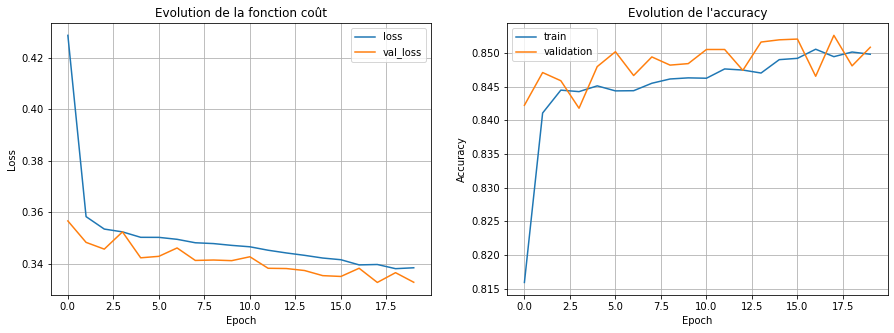

In [12]:
%%time

#inputs des hyperparamètres
epochs = 20
batch_size = 32
u1 = 20
u2 = 16
u3 = 8
activation = 'tanh'
initializer = 'normal'

#construction du modèle
inputs = Input(shape = X_train.shape[1], name='Input')

dense1 = Dense(units = u1, activation = activation, kernel_initializer = initializer, name = 'couche1')
dense2 = Dense(units = u2, activation = activation, kernel_initializer = initializer, name = 'couche2')
dense3 = Dense(units = u3, activation = activation, kernel_initializer = initializer, name = 'couche3')
dense4 = Dense(units = 2, activation = 'softmax', kernel_initializer = initializer, name = 'couche4')

x = dense1(inputs)
x = dense2(x)
x = dense3(x)
outputs = dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()

#compilation et entrainement du modèle
model.compile(loss = 'BinaryCrossentropy', optimizer = 'adam', metrics = ['accuracy'])
train_hist = model.fit(X_train, y_train, 
                       epochs = epochs, 
                       batch_size = batch_size, 
                       validation_split = 0.2, 
                       verbose = True)

#visualisation de l'évolution de la fonction coût
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(train_hist.history['loss'], label='loss')
plt.plot(train_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title("Evolution de la fonction coût");

#visualisation de l'évolution de l'accuracy
plt.subplot(122)
plt.plot(train_hist.history['accuracy'], label='train')
plt.plot(train_hist.history['val_accuracy'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title("Evolution de l'accuracy");
print("_________________________________________________________________")

#évaluation du modèle
print("Valeur de loss :", model.evaluate(X_test, y_test)[0])
print("_________________________________________________________________")

y_pred_train = model.predict(X_train)
y_pred_train_class = np.argmax(y_pred_train, axis=1)

y_pred_test = model.predict(X_test)
y_pred_test_class = np.argmax(y_pred_test, axis=1)

y_test_class = np.argmax(y_test, axis=1)
y_train_class = np.argmax(y_train, axis=1)

print("performances sur train :\n", classification_report(y_train_class, y_pred_train_class))
print("________________________________________________________________")
print("performances sur test :\n", classification_report(y_test_class, y_pred_test_class))


Conclusions : 

Ce premier modèle obtient des performances satisfaisantes avec une accuracy de 85 % et un score F1 dépassant les 60 %.

Pour tenter d'améliorer encore ces performances, nous testerons différentes fonctions d'activation et différents initialiseurs. Le choix de l'initialiseur ne doit pas être négliger car il les poids initiaux du modèle peuvent avoir des conséquences dramatiques sur l'évolution du gradient au cours de l'entrainement.
https://github.com/christianversloot/machine-learning-articles/blob/main/random-initialization-vanishing-and-exploding-gradients.md

Nous testerons deux initialiseurs :
- initialiseur Xavier qui s'utilise avec la fonction d'activation tanh
- initialiseur HeNormal qui s'utilise avec la fonction d'activation ReLu (la plus utilisée)
https://github.com/christianversloot/machine-learning-articles/blob/main/he-xavier-initialization-activation-functions-choose-wisely.md

Nous implémenterons aussi les callbacks EarlyStopping et ReduceLROnPlateau.
L'entrainement sur un très grand nombre d'époques sans callbacks a été testé et ne donne pas de résultats satisfaisants (non présenté ici).

#### Initialiseur Xavier
- nombre d'époques = 100 max (early stopping)
- batch_size = 32
- fonction d'activation = tangente hyperbolique (tanh)
- initialiseur = Xavier (GlorotNormal)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 29)]              0         
                                                                 
 couche1 (Dense)             (None, 20)                600       
                                                                 
 couche2 (Dense)             (None, 16)                336       
                                                                 
 couche3 (Dense)             (None, 8)                 136       
                                                                 
 couche4 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1,090
Trainable params: 1,090
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1132/1132 [==============================] - 

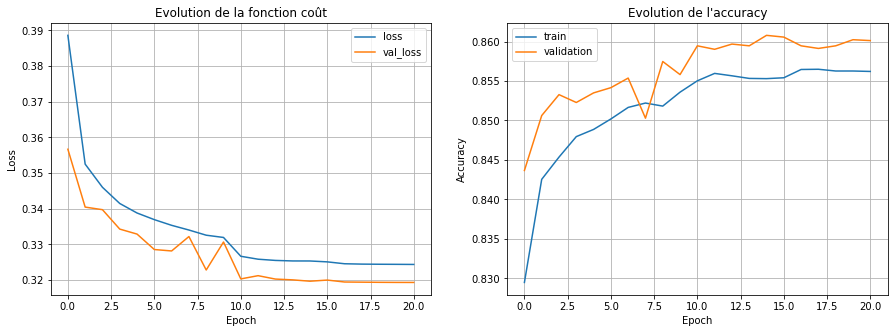

In [16]:
%%time

#création des callbacks
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.005,
                               patience = 12,
                               mode = 'min',
                               verbose = 1)

reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                                         factor = 0.1,
                                         patience = 4,
                                         min_delta = 0.01,
                                         cooldown = 3,
                                         verbose = 1)

#inputs des hyperparamètres
epochs = 100
batch_size = 32
u1 = 20
u2 = 16
u3 = 8
activation = 'tanh'
initializer = tf.keras.initializers.GlorotNormal()

#construction du modèle
inputs = Input(shape = X_train.shape[1], name='Input')

dense1 = Dense(units = u1, activation = activation, kernel_initializer = initializer, name = 'couche1')
dense2 = Dense(units = u2, activation = activation, kernel_initializer = initializer, name = 'couche2')
dense3 = Dense(units = u3, activation = activation, kernel_initializer = initializer, name = 'couche3')
dense4 = Dense(units = 2, activation = 'softmax', kernel_initializer = initializer, name = 'couche4')

x = dense1(inputs)
x = dense2(x)
x = dense3(x)
outputs = dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()

#compilation et entrainement du modèle
model.compile(loss = 'BinaryCrossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

train_hist = model.fit(X_train, y_train, 
                       epochs = epochs, 
                       batch_size = batch_size, 
                       validation_split = 0.2,
                       callbacks = [reduce_learning_rate, early_stopping],
                       verbose = True)

#visualisation de l'évolution de la fonction coût
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(train_hist.history['loss'], label='loss')
plt.plot(train_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title("Evolution de la fonction coût");

#visualisation de l'évolution de l'accuracy
plt.subplot(122)
plt.plot(train_hist.history['accuracy'], label='train')
plt.plot(train_hist.history['val_accuracy'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title("Evolution de l'accuracy");
print("_________________________________________________________________")

#évaluation du modèle
print("Valeur de loss :", model.evaluate(X_test, y_test)[0])
print("_________________________________________________________________")

y_pred_train = model.predict(X_train)
y_pred_train_class = np.argmax(y_pred_train, axis=1)

y_pred_test = model.predict(X_test)
y_pred_test_class = np.argmax(y_pred_test, axis=1)

y_test_class = np.argmax(y_test, axis=1)
y_train_class = np.argmax(y_train, axis=1)

print("performances sur train :\n", classification_report(y_train_class, y_pred_train_class))
print("________________________________________________________________")
print("performances sur test :\n", classification_report(y_test_class, y_pred_test_class))


Conclusion :

Les performances sont très proches du modèles de référence, tantôt légèrement meilleures, tantôt légèrement moins bonnes, selon les entrainements. L'évolution des courbes apparait toutefois plus régulière avec une bonne stabilisation des métriques après 10 époques.

#### Initialiseur HeNormal
- nombre d'époques = 100 max (early stopping)
- batch_size = 32
- fonction d'activation = ReLu
- initialiseur = HeNormal

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 29)]              0         
                                                                 
 couche1 (Dense)             (None, 20)                600       
                                                                 
 couche2 (Dense)             (None, 16)                336       
                                                                 
 couche3 (Dense)             (None, 8)                 136       
                                                                 
 couche4 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1,090
Trainable params: 1,090
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1132/1132 [==============================] - 

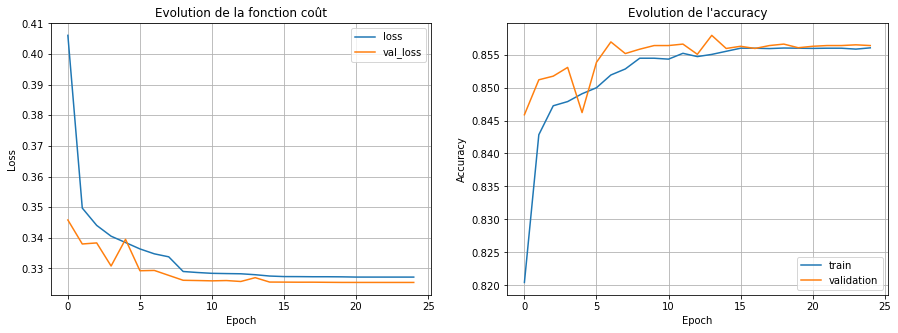

In [18]:
%%time

#création des callbacks
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.005,
                               patience = 12,
                               mode = 'min',
                               verbose = 1)

reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                                         factor = 0.1,
                                         patience = 4,
                                         min_delta = 0.01,
                                         cooldown = 3,
                                         verbose = 1)

#inputs des hyperparamètres
epochs = 100
batch_size = 32
u1 = 20
u2 = 16
u3 = 8
activation = 'relu'
initializer = tf.keras.initializers.HeNormal()

#construction du modèle
inputs = Input(shape = X_train.shape[1], name='Input')

dense1 = Dense(units = u1, activation = activation, kernel_initializer = initializer, name = 'couche1')
dense2 = Dense(units = u2, activation = activation, kernel_initializer = initializer, name = 'couche2')
dense3 = Dense(units = u3, activation = activation, kernel_initializer = initializer, name = 'couche3')
dense4 = Dense(units = 2, activation = 'softmax', kernel_initializer = initializer, name = 'couche4')

x = dense1(inputs)
x = dense2(x)
x = dense3(x)
outputs = dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()

#compilation et entrainement du modèle
model.compile(loss = 'BinaryCrossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

train_hist = model.fit(X_train, y_train, 
                       epochs = epochs, 
                       batch_size = batch_size, 
                       validation_split = 0.2,
                       callbacks = [reduce_learning_rate, early_stopping],
                       verbose = True)

#visualisation de l'évolution de la fonction coût
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(train_hist.history['loss'], label='loss')
plt.plot(train_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title("Evolution de la fonction coût");

#visualisation de l'évolution de l'accuracy
plt.subplot(122)
plt.plot(train_hist.history['accuracy'], label='train')
plt.plot(train_hist.history['val_accuracy'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title("Evolution de l'accuracy");
print("_________________________________________________________________")

#évaluation du modèle
print("Valeur de loss :", model.evaluate(X_test, y_test)[0])
print("_________________________________________________________________")

y_pred_train = model.predict(X_train)
y_pred_train_class = np.argmax(y_pred_train, axis=1)

y_pred_test = model.predict(X_test)
y_pred_test_class = np.argmax(y_pred_test, axis=1)

y_test_class = np.argmax(y_test, axis=1)
y_train_class = np.argmax(y_train, axis=1)

print("performances sur train :\n", classification_report(y_train_class, y_pred_train_class))
print("________________________________________________________________")
print("performances sur test :\n", classification_report(y_test_class, y_pred_test_class))


Conclusion : 

Les performances sont similaires à celles du modèles de référence. Notons toutefois que les valeurs de la fonction coût et de l'accuracy de l'échantillon de validation convergent mieux vers celles de l'entrainement que les modèles précédents. 
Nous conserverons ces hyperparamètres pour cette raison et parce que ce sont les plus utilisés actuellement (en particulier la fonction d'activation ReLu).

L'objectif de la prochaine session est de tester une taille de batch plus petite.

#### batch de taille 16
- nombre d'époques = 100 max (early stopping)
- batch_size = 16
- fonction d'activation = ReLu
- initialiseur = HeNormal

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 29)]              0         
                                                                 
 couche1 (Dense)             (None, 20)                600       
                                                                 
 couche2 (Dense)             (None, 16)                336       
                                                                 
 couche3 (Dense)             (None, 8)                 136       
                                                                 
 couche4 (Dense)             (None, 2)                 18        
                                                                 
Total params: 1,090
Trainable params: 1,090
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2263/2263 [==============================] - 

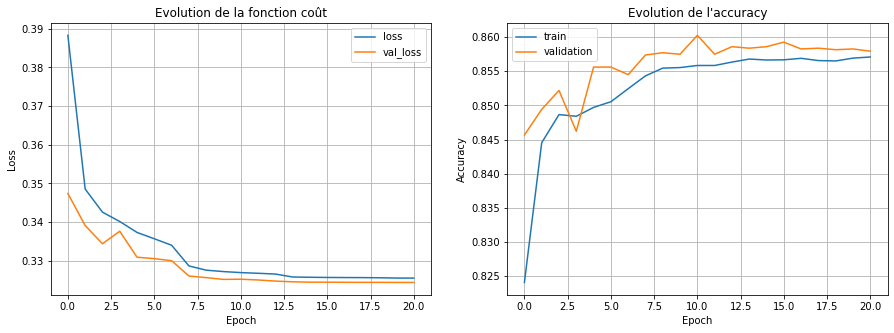

In [19]:
%%time

#création des callbacks
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.005,
                               patience = 12,
                               mode = 'min',
                               verbose = 1)

reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                                         factor = 0.1,
                                         patience = 4,
                                         min_delta = 0.01,
                                         cooldown = 3,
                                         verbose = 1)

#inputs des hyperparamètres
epochs = 100
batch_size = 16
u1 = 20
u2 = 16
u3 = 8
activation = 'relu'
initializer = tf.keras.initializers.HeNormal()

#construction du modèle
inputs = Input(shape = X_train.shape[1], name='Input')

dense1 = Dense(units = u1, activation = activation, kernel_initializer = initializer, name = 'couche1')
dense2 = Dense(units = u2, activation = activation, kernel_initializer = initializer, name = 'couche2')
dense3 = Dense(units = u3, activation = activation, kernel_initializer = initializer, name = 'couche3')
dense4 = Dense(units = 2, activation = 'softmax', kernel_initializer = initializer, name = 'couche4')

x = dense1(inputs)
x = dense2(x)
x = dense3(x)
outputs = dense4(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()

#compilation et entrainement du modèle
model.compile(loss = 'BinaryCrossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

train_hist = model.fit(X_train, y_train, 
                       epochs = epochs, 
                       batch_size = batch_size, 
                       validation_split = 0.2,
                       callbacks = [reduce_learning_rate, early_stopping],
                       verbose = True)

#visualisation de l'évolution de la fonction coût
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(train_hist.history['loss'], label='loss')
plt.plot(train_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title("Evolution de la fonction coût");

#visualisation de l'évolution de l'accuracy
plt.subplot(122)
plt.plot(train_hist.history['accuracy'], label='train')
plt.plot(train_hist.history['val_accuracy'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title("Evolution de l'accuracy");
print("_________________________________________________________________")

#évaluation du modèle
print("Valeur de loss :", model.evaluate(X_test, y_test)[0])
print("_________________________________________________________________")

y_pred_train = model.predict(X_train)
y_pred_train_class = np.argmax(y_pred_train, axis=1)

y_pred_test = model.predict(X_test)
y_pred_test_class = np.argmax(y_pred_test, axis=1)

y_test_class = np.argmax(y_test, axis=1)
y_train_class = np.argmax(y_train, axis=1)

print("performances sur train :\n", classification_report(y_train_class, y_pred_train_class))
print("________________________________________________________________")
print("performances sur test :\n", classification_report(y_test_class, y_pred_test_class))


Conclusion :

La modification de la taille du batch n'a pas eu de conséquence sur les performances. 

<i>Remarque : Nous avons également testé d'autres tailles de batch, notamment 64, non présentées ici.</i>

Dans la section suivante, nous testons un réseau plus important composé de 5 couches contenant plus de neurones.

### 5 couches Dense avec plus de neurones
- nombre d'époques = 100 max (early stopping)
- batch_size = 32
- fonction d'activation = ReLu
- initialiseur = HeNormal

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 29)]              0         
                                                                 
 couche1 (Dense)             (None, 256)               7680      
                                                                 
 couche2 (Dense)             (None, 128)               32896     
                                                                 
 couche3 (Dense)             (None, 64)                8256      
                                                                 
 couche4 (Dense)             (None, 32)                2080      
                                                                 
 couche5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 50,978
Trainable params: 50,978
Non-trainabl

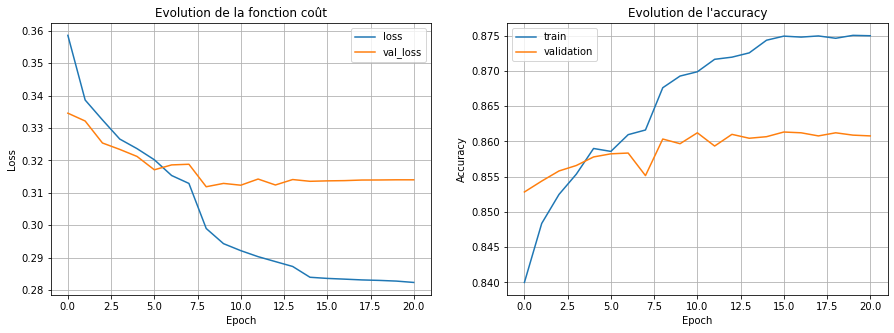

In [21]:
%%time

#création des callbacks
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.005,
                               patience = 12,
                               mode = 'min',
                               verbose = 1)

reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                                         factor = 0.1,
                                         patience = 4,
                                         min_delta = 0.01,
                                         cooldown = 3,
                                         verbose = 1)

#inputs des hyperparamètres
epochs = 100
batch_size = 32
u1 = 256
u2 = 128
u3 = 64
u4 = 32
activation = 'relu'
initializer = tf.keras.initializers.HeNormal()

#construction du modèle
inputs = Input(shape = X_train.shape[1], name='Input')

dense1 = Dense(units = u1, activation = activation, kernel_initializer = initializer, name = 'couche1')
dense2 = Dense(units = u2, activation = activation, kernel_initializer = initializer, name = 'couche2')
dense3 = Dense(units = u3, activation = activation, kernel_initializer = initializer, name = 'couche3')
dense4 = Dense(units = u4, activation = activation, kernel_initializer = initializer, name = 'couche4')
dense5 = Dense(units = 2, activation = 'softmax', kernel_initializer = initializer, name = 'couche5')

x = dense1(inputs)
x = dense2(x)
x = dense3(x)
x = dense4(x)
outputs = dense5(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()

#compilation et entrainement du modèle
model.compile(loss = 'BinaryCrossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

train_hist = model.fit(X_train, y_train, 
                       epochs = epochs, 
                       batch_size = batch_size, 
                       validation_split = 0.2,
                       callbacks = [reduce_learning_rate, early_stopping],
                       verbose = True)

#visualisation de l'évolution de la fonction coût
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(train_hist.history['loss'], label='loss')
plt.plot(train_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title("Evolution de la fonction coût");

#visualisation de l'évolution de l'accuracy
plt.subplot(122)
plt.plot(train_hist.history['accuracy'], label='train')
plt.plot(train_hist.history['val_accuracy'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title("Evolution de l'accuracy");
print("_________________________________________________________________")

#évaluation du modèle
print("Valeur de loss :", model.evaluate(X_test, y_test)[0])
print("_________________________________________________________________")

y_pred_train = model.predict(X_train)
y_pred_train_class = np.argmax(y_pred_train, axis=1)

y_pred_test = model.predict(X_test)
y_pred_test_class = np.argmax(y_pred_test, axis=1)

y_test_class = np.argmax(y_test, axis=1)
y_train_class = np.argmax(y_train, axis=1)

print("performances sur train :\n", classification_report(y_train_class, y_pred_train_class))
print("________________________________________________________________")
print("performances sur test :\n", classification_report(y_test_class, y_pred_test_class))


Conclusion : 

Les performances sont similaires à celles obtenues par le réseau plus petit. On note que les métriques sur l'échantillon de validation se stabilisent après huit époques alors qu'elles continuent d'évoluer sur l'échantillon d'entrainement.

<i>Remarque : L'ajout d'encore plus de neurones ne permet pas d'améliorer les performances (autres réseaux non présentés ici).</i>

## 1.2 - Jeu de données sous-échantillonné

Le modèle est entrainé sur le jeu de données rééchantillonné par l'algorithme RandomUnderSampler.

#### Avec callbacks
- nombre d'époques = 100 max (early stopping)
- batch_size = 32
- fonction d'activation = ReLu
- initialiseur = HeNormal

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 29)]              0         
                                                                 
 couche1 (Dense)             (None, 256)               7680      
                                                                 
 couche2 (Dense)             (None, 128)               32896     
                                                                 
 couche3 (Dense)             (None, 64)                8256      
                                                                 
 couche4 (Dense)             (None, 32)                2080      
                                                                 
 couche5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 50,978
Trainable params: 50,978
Non-trainabl

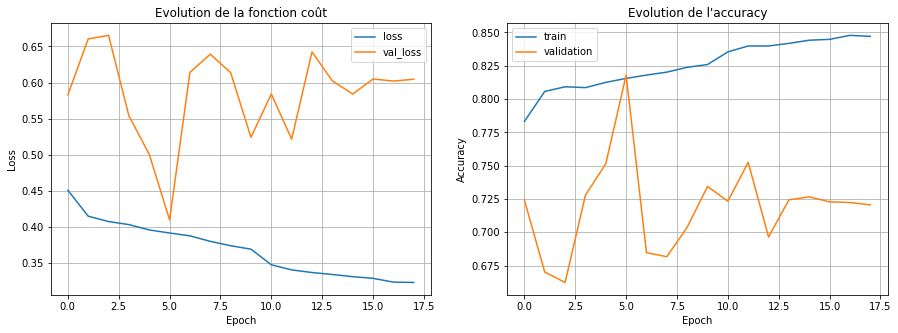

In [23]:
%%time

#création des callbacks
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.005,
                               patience = 12,
                               mode = 'min',
                               verbose = 1)

reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                                         factor = 0.1,
                                         patience = 4,
                                         min_delta = 0.01,
                                         cooldown = 3,
                                         verbose = 1)

#inputs des hyperparamètres
epochs = 100
batch_size = 32
u1 = 256
u2 = 128
u3 = 64
u4 = 32
activation = 'relu'
initializer = tf.keras.initializers.HeNormal()

#construction du modèle
inputs = Input(shape = X_train.shape[1], name='Input')

dense1 = Dense(units = u1, activation = activation, kernel_initializer = initializer, name = 'couche1')
dense2 = Dense(units = u2, activation = activation, kernel_initializer = initializer, name = 'couche2')
dense3 = Dense(units = u3, activation = activation, kernel_initializer = initializer, name = 'couche3')
dense4 = Dense(units = u4, activation = activation, kernel_initializer = initializer, name = 'couche4')
dense5 = Dense(units = 2, activation = 'softmax', kernel_initializer = initializer, name = 'couche5')

x = dense1(inputs)
x = dense2(x)
x = dense3(x)
x = dense4(x)
outputs = dense5(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()

#compilation et entrainement du modèle
model.compile(loss = 'BinaryCrossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

train_hist = model.fit(X_train_ru, y_train_ru, 
                       epochs = epochs, 
                       batch_size = batch_size, 
                       validation_split = 0.2,
                       callbacks = [reduce_learning_rate, early_stopping],
                       verbose = True)

#visualisation de l'évolution de la fonction coût
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(train_hist.history['loss'], label='loss')
plt.plot(train_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title("Evolution de la fonction coût");

#visualisation de l'évolution de l'accuracy
plt.subplot(122)
plt.plot(train_hist.history['accuracy'], label='train')
plt.plot(train_hist.history['val_accuracy'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title("Evolution de l'accuracy");
print("_________________________________________________________________")

#évaluation du modèle
print("Valeur de loss :", model.evaluate(X_test_ru, y_test_ru)[0])
print("_________________________________________________________________")

y_pred_train_ru = model.predict(X_train_ru)
y_pred_train_class_ru = np.argmax(y_pred_train_ru, axis=1)

y_pred_test_ru = model.predict(X_test_ru)
y_pred_test_class_ru = np.argmax(y_pred_test_ru, axis=1)

y_test_class_ru = np.argmax(y_test_ru, axis=1)
y_train_class_ru = np.argmax(y_train_ru, axis=1)

print("performances sur train :\n", classification_report(y_train_class_ru, y_pred_train_class_ru))
print("________________________________________________________________")
print("performances sur test :\n", classification_report(y_test_class_ru, y_pred_test_class_ru))

Conclusion :
Les métriques globales montrent des performances similaires à celles obtenues sur le jeu de données déséquilibré avec une accuracy dépassant 80 % et un score F1 proche de 65 %.

Comme pour les modèles de machine learning classiques, la précision est moins bonne mais le rappel est meilleur que sur le jeu de données déséquilibré.

L'évolution de la fonction coût et de l'accuracy est très irrégulière et leur stabilisation n'est pas évidente sur 18 époques. Nous allons donc tester le modèle sur 50 époques sans callbacks.

#### Essai sur 50 epochs sans callbacks
- nombre d'époques = 50
- batch_size = 32
- fonction d'activation = ReLu
- initialiseur = HeNormal
##### Objectif : visualiser l'évolution des courbes d'accuracy et de fonction coût

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 29)]              0         
                                                                 
 couche1 (Dense)             (None, 256)               7680      
                                                                 
 couche2 (Dense)             (None, 128)               32896     
                                                                 
 couche3 (Dense)             (None, 64)                8256      
                                                                 
 couche4 (Dense)             (None, 32)                2080      
                                                                 
 couche5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 50,978
Trainable params: 50,978
Non-trainabl

Epoch 50/50
498/498 [==============================] - 1s 2ms/step - loss: 0.1006 - accuracy: 0.9614 - val_loss: 1.7302 - val_accuracy: 0.6824
_________________________________________________________________
354/354 [==============================] - 1s 1ms/step - loss: 0.9834 - accuracy: 0.8029
Valeur de loss : 0.9834005832672119
_________________________________________________________________
performances sur train :
               precision    recall  f1-score   support

           0       0.86      0.98      0.92      9956
           1       0.98      0.84      0.90      9956

    accuracy                           0.91     19912
   macro avg       0.92      0.91      0.91     19912
weighted avg       0.92      0.91      0.91     19912

________________________________________________________________
performances sur test :
               precision    recall  f1-score   support

           0       0.90      0.84      0.87      8842
           1       0.54      0.67      0.60     

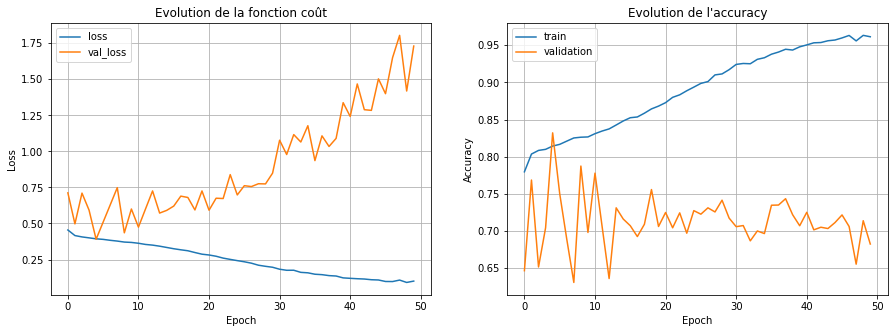

In [24]:
%%time

#inputs des hyperparamètres
epochs = 50
batch_size = 32
u1 = 256
u2 = 128
u3 = 64
u4 = 32
activation = 'relu'
initializer = tf.keras.initializers.HeNormal()

#construction du modèle
inputs = Input(shape = X_train.shape[1], name='Input')

dense1 = Dense(units = u1, activation = activation, kernel_initializer = initializer, name = 'couche1')
dense2 = Dense(units = u2, activation = activation, kernel_initializer = initializer, name = 'couche2')
dense3 = Dense(units = u3, activation = activation, kernel_initializer = initializer, name = 'couche3')
dense4 = Dense(units = u4, activation = activation, kernel_initializer = initializer, name = 'couche4')
dense5 = Dense(units = 2, activation = 'softmax', kernel_initializer = initializer, name = 'couche5')

x = dense1(inputs)
x = dense2(x)
x = dense3(x)
x = dense4(x)
outputs = dense5(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()

#compilation et entrainement du modèle
model.compile(loss = 'BinaryCrossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

train_hist = model.fit(X_train_ru, y_train_ru, 
                       epochs = epochs, 
                       batch_size = batch_size, 
                       validation_split = 0.2,
                       verbose = True)

#visualisation de l'évolution de la fonction coût
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(train_hist.history['loss'], label='loss')
plt.plot(train_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title("Evolution de la fonction coût");

#visualisation de l'évolution de l'accuracy
plt.subplot(122)
plt.plot(train_hist.history['accuracy'], label='train')
plt.plot(train_hist.history['val_accuracy'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title("Evolution de l'accuracy");
print("_________________________________________________________________")

#évaluation du modèle
print("Valeur de loss :", model.evaluate(X_test_ru, y_test_ru)[0])
print("_________________________________________________________________")

y_pred_train_ru = model.predict(X_train_ru)
y_pred_train_class_ru = np.argmax(y_pred_train_ru, axis=1)

y_pred_test_ru = model.predict(X_test_ru)
y_pred_test_class_ru = np.argmax(y_pred_test_ru, axis=1)

y_test_class_ru = np.argmax(y_test_ru, axis=1)
y_train_class_ru = np.argmax(y_train_ru, axis=1)

print("performances sur train :\n", classification_report(y_train_class_ru, y_pred_train_class_ru))
print("________________________________________________________________")
print("performances sur test :\n", classification_report(y_test_class_ru, y_pred_test_class_ru))

Conclusion :

L'évolution des courbes montrent des irrégularité, les fonctions ne se stabilisent pas.
Le rééchantillonnage semble donc perturber le modèle sur ce point, même si les performances globales restent bonnes.

## 1.3 - Après sur-échantillonnage

Le modèle est entrainé sur le jeu de données rééchantillonné par l'algorithme RandomOverSampler.

#### Avec callbacks
- nombre d'époques = 100 max (early stopping)
- batch_size = 32
- fonction d'activation = ReLu
- initialiseur = HeNormal

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 29)]              0         
                                                                 
 couche1 (Dense)             (None, 256)               7680      
                                                                 
 couche2 (Dense)             (None, 128)               32896     
                                                                 
 couche3 (Dense)             (None, 64)                8256      
                                                                 
 couche4 (Dense)             (None, 32)                2080      
                                                                 
 couche5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 50,978
Trainable params: 50,978
Non-trainabl

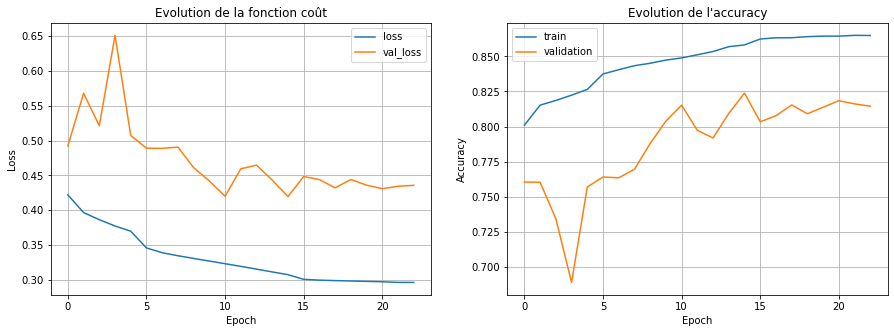

In [26]:
%%time

#création des callbacks
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0.005,
                               patience = 12,
                               mode = 'min',
                               verbose = 1)

reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                                         factor = 0.1,
                                         patience = 4,
                                         min_delta = 0.01,
                                         cooldown = 3,
                                         verbose = 1)

#inputs des hyperparamètres
epochs = 100
batch_size = 32
u1 = 256
u2 = 128
u3 = 64
u4 = 32
activation = 'relu'
initializer = tf.keras.initializers.HeNormal()

#construction du modèle
inputs = Input(shape = X_train.shape[1], name='Input')

dense1 = Dense(units = u1, activation = activation, kernel_initializer = initializer, name = 'couche1')
dense2 = Dense(units = u2, activation = activation, kernel_initializer = initializer, name = 'couche2')
dense3 = Dense(units = u3, activation = activation, kernel_initializer = initializer, name = 'couche3')
dense4 = Dense(units = u4, activation = activation, kernel_initializer = initializer, name = 'couche4')
dense5 = Dense(units = 2, activation = 'softmax', kernel_initializer = initializer, name = 'couche5')

x = dense1(inputs)
x = dense2(x)
x = dense3(x)
x = dense4(x)
outputs = dense5(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()

#compilation et entrainement du modèle
model.compile(loss = 'BinaryCrossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

train_hist = model.fit(X_train_ro, y_train_ro, 
                       epochs = epochs, 
                       batch_size = batch_size, 
                       validation_split = 0.2,
                       callbacks = [reduce_learning_rate, early_stopping],
                       verbose = True)

#visualisation de l'évolution de la fonction coût
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(train_hist.history['loss'], label='loss')
plt.plot(train_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title("Evolution de la fonction coût");

#visualisation de l'évolution de l'accuracy
plt.subplot(122)
plt.plot(train_hist.history['accuracy'], label='train')
plt.plot(train_hist.history['val_accuracy'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title("Evolution de l'accuracy");
print("_________________________________________________________________")

#évaluation du modèle
print("Valeur de loss :", model.evaluate(X_test_ro, y_test_ro)[0])
print("_________________________________________________________________")

y_pred_train_ro = model.predict(X_train_ro)
y_pred_train_class_ro = np.argmax(y_pred_train_ro, axis=1)

y_pred_test_ro = model.predict(X_test_ro)
y_pred_test_class_ro = np.argmax(y_pred_test_ro, axis=1)

y_test_class_ro = np.argmax(y_test_ro, axis=1)
y_train_class_ro = np.argmax(y_train_ro, axis=1)

print("performances sur train :\n", classification_report(y_train_class_ro, y_pred_train_class_ro))
print("________________________________________________________________")
print("performances sur test :\n", classification_report(y_test_class_ro, y_pred_test_class_ro))

Conclusion :
Les performances et l'évolution des métriques sont comparables à celles du modèle entrainé sur le jeu de donnée sous-échantillonné.

#### Essai sur 50 époques sans callbacks
- nombre d'époques = 50
- batch_size = 32
- fonction d'activation = ReLu
- initialiseur = HeNormal
##### Objectif : visualiser l'évolution des courbes d'accuracy et de fonction coût

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 29)]              0         
                                                                 
 couche1 (Dense)             (None, 256)               7680      
                                                                 
 couche2 (Dense)             (None, 128)               32896     
                                                                 
 couche3 (Dense)             (None, 64)                8256      
                                                                 
 couche4 (Dense)             (None, 32)                2080      
                                                                 
 couche5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 50,978
Trainable params: 50,978
Non-trainabl

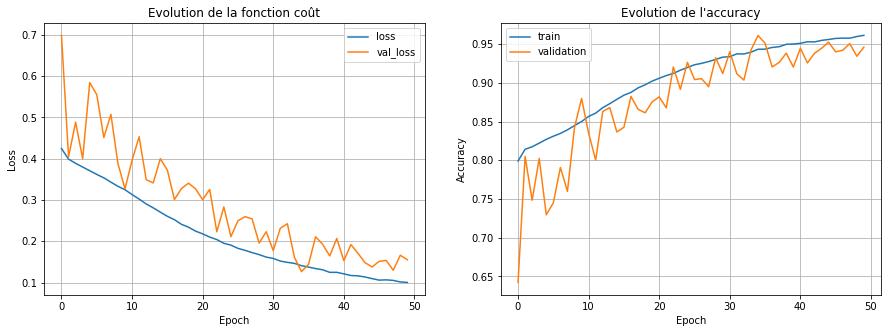

In [27]:
%%time

#inputs des hyperparamètres
epochs = 50
batch_size = 32
u1 = 256
u2 = 128
u3 = 64
u4 = 32
activation = 'relu'
initializer = tf.keras.initializers.HeNormal()

#construction du modèle
inputs = Input(shape = X_train.shape[1], name='Input')

dense1 = Dense(units = u1, activation = activation, kernel_initializer = initializer, name = 'couche1')
dense2 = Dense(units = u2, activation = activation, kernel_initializer = initializer, name = 'couche2')
dense3 = Dense(units = u3, activation = activation, kernel_initializer = initializer, name = 'couche3')
dense4 = Dense(units = u4, activation = activation, kernel_initializer = initializer, name = 'couche4')
dense5 = Dense(units = 2, activation = 'softmax', kernel_initializer = initializer, name = 'couche5')

x = dense1(inputs)
x = dense2(x)
x = dense3(x)
x = dense4(x)
outputs = dense5(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()

#compilation et entrainement du modèle
model.compile(loss = 'BinaryCrossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

train_hist = model.fit(X_train_ro, y_train_ro, 
                       epochs = epochs, 
                       batch_size = batch_size, 
                       validation_split = 0.2,
                       verbose = True)

#visualisation de l'évolution de la fonction coût
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(train_hist.history['loss'], label='loss')
plt.plot(train_hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title("Evolution de la fonction coût");

#visualisation de l'évolution de l'accuracy
plt.subplot(122)
plt.plot(train_hist.history['accuracy'], label='train')
plt.plot(train_hist.history['val_accuracy'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title("Evolution de l'accuracy");
print("_________________________________________________________________")

#évaluation du modèle
print("Valeur de loss :", model.evaluate(X_test_ro, y_test_ro)[0])
print("_________________________________________________________________")

y_pred_train_ro = model.predict(X_train_ro)
y_pred_train_class_ro = np.argmax(y_pred_train_ro, axis=1)

y_pred_test_ro = model.predict(X_test_ro)
y_pred_test_class_ro = np.argmax(y_pred_test_ro, axis=1)

y_test_class_ro = np.argmax(y_test_ro, axis=1)
y_train_class_ro = np.argmax(y_train_ro, axis=1)

print("performances sur train :\n", classification_report(y_train_class_ro, y_pred_train_class_ro))
print("________________________________________________________________")
print("performances sur test :\n", classification_report(y_test_class_ro, y_pred_test_class_ro))

Conslusion :

Même observation que pour le modèle entrainé sur le jeu de données sous-échantillonné : les métriques se stabilisent mal sur l'échantillon de validation.

## Conclusion pour les modèles Dense de Keras

- Sur un jeu de données rééchantillonné, les modèles Dense obtiennent des performances similaires à celles des meilleurs modèles de machine learning classiques, sans toutefois les dépasser.
- L'ajout de couches et de neurones supplémentaires n'améliorent pas les scores de façon significative et les écarts de performance sont aléatoires (légères variations d'un entrainement à l'autre). Les différentes fonctions d'activation et initialiseurs couramment utilisés donnent des performances similaires.
- Le rééchantillonnage des classes n'améliore pas les performances des modèles qui sont similaires. On observe les mêmes différences entre précision et rappel que pour les modèles de machine learning classiques. L'évolution des métriques au cours des époques est plus erratique après rééchantillonnage.

<hr>
<h1> 2 - Modèles FastAI </h1>
<hr>

## Installation des packages nécessaires à l'utilisation de FastAI

In [1]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.0/708.0 MB 1.4 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 11.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1
    Uninstalling torchvision-0.10.1:
      Successfully uninstalled torchvision-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 1.6.1 requires torch>=1.8.*, but you have torch 1.6.0+cu101 which is incompatible.
fastai 2.6.0 requires torch<1.12,>=1.7.0, but you have torch 1.6.0+cu101 which is incompatible.
fastai 2.6.0 requires torchvision>=0.8.2, but you have t

In [2]:
!pip install --upgrade kornia
!pip install allennlp==1.1.0.rc4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.4/493.4 KB 674.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.5 MB/s eta 0:00:0000:0100:02
  Attempting uninstall: torch
    Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Attempting uninstall: kornia
    Found existing installation: kornia 0.5.8
    Uninstalling kornia-0.5.8:
      Successfully uninstalled kornia-0.5.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.7.0+cu101 requires torch==1.6.0, but you have torch 1.11.0 which is incompatible.
fastai 2.6.0 requires torchvision>=0.8.2, but you have torchvision 0.7.0+cu101 which is incompatible.
allennlp 2.9.3 requires torchvision<0.13.0,>=0.8.1, but you have torchvision 0.7.0+cu101 which is incompatible.
     ━━━━━━━━━━━

In [3]:
!pip install --upgrade fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.9/197.9 KB 444.9 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 11.5 MB/s eta 0:00:0000:0100:01
  Using cached torch-1.11.0-cp37-cp37m-manylinux1_x86_64.whl (750.6 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.6.0
    Uninstalling torch-1.6.0:
      Successfully uninstalled torch-1.6.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
  Attempting uninstall: fastai
    Found existing installation: fastai 2.6.0
    Uninstalling fastai-2.6.0:
      Successfully uninstalled fastai-2.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 1.1.0rc4 requires torch<1.7.0,>=1.6.0, but you have torch 1.11.0 which i

In [4]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

import fastai
print(fastai.__version__)

from fastai.vision.all import *

1.11.0+cu102
True
2.6.3


In [5]:
import fastai as fs

from fastai import *
from fastai.vision import *
from fastai.tabular.data import *

In [6]:
help(fs.tabular)

Help on package fastai.tabular in fastai:

NAME
    fastai.tabular

PACKAGE CONTENTS
    all
    core
    data
    learner
    model

FILE
    /opt/conda/lib/python3.7/site-packages/fastai/tabular/__init__.py




In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
import os
print(os.listdir("../input"))

['weatheraus-rev3csv']


## Preprocessing

In [11]:
features = ["RainToday_Num","Rainfall","Rain_J-1","Rain_J-2","MinTemp","MaxTemp","Sunshine","Evaporation",
            "Humidity3pm","Humidity9am","Pressure9am","Pressure3pm","Cloud3pm","Cloud9am", 
            "Wind9am_cos","Wind3pm_cos","WindGust_cos","Wind9am_sin","Wind3pm_sin","WindGust_sin",
            "Mois_sin", "Mois_cos", "Climat_Koppen","RainTomorrow_Num"]

In [12]:
X = df[features]

In [13]:
#Suppression des climats
X=X.drop("Climat_Koppen",axis=1)

In [14]:
cat_col_names = list(X.select_dtypes('object').columns)
cat_col_names
num_col_names = list(X.select_dtypes('float64').columns)+list(X.select_dtypes('int64').columns)
num_col_names.pop()
num_col_names

['Rainfall',
 'Rain_J-1',
 'Rain_J-2',
 'MinTemp',
 'MaxTemp',
 'Sunshine',
 'Evaporation',
 'Humidity3pm',
 'Humidity9am',
 'Pressure9am',
 'Pressure3pm',
 'Wind9am_cos',
 'Wind3pm_cos',
 'WindGust_cos',
 'Wind9am_sin',
 'Wind3pm_sin',
 'WindGust_sin',
 'Mois_sin',
 'Mois_cos',
 'RainToday_Num',
 'Cloud3pm',
 'Cloud9am']

In [15]:
dep_var = "RainTomorrow_Num"

print("Categorical columns are : ", cat_col_names)
print('Continuous numerical columns are :', num_col_names)
procs = ['FillMissing', 'Categorify', 'Normalize']

Categorical columns are :  []
Continuous numerical columns are : ['Rainfall', 'Rain_J-1', 'Rain_J-2', 'MinTemp', 'MaxTemp', 'Sunshine', 'Evaporation', 'Humidity3pm', 'Humidity9am', 'Pressure9am', 'Pressure3pm', 'Wind9am_cos', 'Wind3pm_cos', 'WindGust_cos', 'Wind9am_sin', 'Wind3pm_sin', 'WindGust_sin', 'Mois_sin', 'Mois_cos', 'RainToday_Num', 'Cloud3pm', 'Cloud9am']


In [19]:
#préparation des JD d'entrainement et de test
from sklearn.model_selection import train_test_split
X_tr, X_te = train_test_split(X, test_size=0.2, random_state=123)
X_tr.info()

#préparation des jeux de données sous-échantillonnés et sur-échantillonnés

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

rus = RandomUnderSampler()
X_train_ru,y_ru = rus.fit_resample(X_tr,X_tr["RainTomorrow_Num"])
print("sous-échantillonage :", X_train_ru.shape[0], "lignes.")

ros = RandomOverSampler()
X_train_ro,y_ro = ros.fit_resample(X_tr,X_tr["RainTomorrow_Num"])
print("sur-échantillonage :", X_train_ro.shape[0], "lignes.")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116364 entries, 51937 to 15725
Data columns (total 23 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   RainToday_Num     116364 non-null  int64  
 1   Rainfall          116364 non-null  float64
 2   Rain_J-1          116364 non-null  float64
 3   Rain_J-2          116364 non-null  float64
 4   MinTemp           116364 non-null  float64
 5   MaxTemp           116364 non-null  float64
 6   Sunshine          116364 non-null  float64
 7   Evaporation       116364 non-null  float64
 8   Humidity3pm       116364 non-null  float64
 9   Humidity9am       116364 non-null  float64
 10  Pressure9am       116364 non-null  float64
 11  Pressure3pm       116364 non-null  float64
 12  Cloud3pm          116364 non-null  int64  
 13  Cloud9am          116364 non-null  int64  
 14  Wind9am_cos       116364 non-null  float64
 15  Wind3pm_cos       116364 non-null  float64
 16  WindGust_cos     

In [20]:
cat_col_names

[]

In [21]:
num_col_names

['Rainfall',
 'Rain_J-1',
 'Rain_J-2',
 'MinTemp',
 'MaxTemp',
 'Sunshine',
 'Evaporation',
 'Humidity3pm',
 'Humidity9am',
 'Pressure9am',
 'Pressure3pm',
 'Wind9am_cos',
 'Wind3pm_cos',
 'WindGust_cos',
 'Wind9am_sin',
 'Wind3pm_sin',
 'WindGust_sin',
 'Mois_sin',
 'Mois_cos',
 'RainToday_Num',
 'Cloud3pm',
 'Cloud9am']

In [22]:
train = TabularDataLoaders.from_df(X_tr, cat_names=cat_col_names, cont_names=num_col_names,y_names=dep_var,y_block = CategoryBlock())
train_ru = TabularDataLoaders.from_df(X_train_ru, cat_names=cat_col_names, cont_names=num_col_names,y_names=dep_var,y_block = CategoryBlock())
train_ro = TabularDataLoaders.from_df(X_train_ro, cat_names=cat_col_names, cont_names=num_col_names,y_names=dep_var,y_block = CategoryBlock())






##### Get a Learner using data, with metrics, including a TabularModel

In [23]:
from fastai.tabular.all import *
tab_learn = tabular_learner(train, metrics=[accuracy, error_rate, Recall(), F1Score(),Precision()])
tab_learn_ru = tabular_learner(train_ru, metrics=[accuracy, error_rate, Recall(), F1Score(),Precision()])
tab_learn_ro = tabular_learner(train_ro, metrics=[accuracy, error_rate, Recall(), F1Score(),Precision()])

In [24]:
tab_learn.model
tab_learn_ru.model
tab_learn_ro.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=22, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

## Recherche du taux d'apprentissage adapté à notre modèle

SuggestedLRs(valley=0.0020892962347716093)

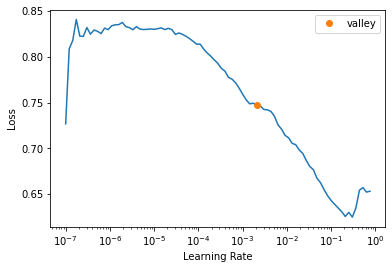

In [25]:
tab_learn.lr_find()

In [26]:
tab_learn.fit_one_cycle(20, lr_max=0.005)

epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,f1_score,precision_score,time
0,0.365368,0.361009,0.842472,0.157528,0.527553,0.593028,0.677060,00:13
1,0.357486,0.358764,0.844964,0.155036,0.555402,0.609185,0.674502,00:12
2,0.361025,0.355420,0.845523,0.154477,0.541576,0.604031,0.682769,00:12
3,0.359743,0.361253,0.843804,0.156196,0.408849,0.532476,0.763274,00:13
4,0.345783,0.347624,0.849218,0.150782,0.482323,0.581913,0.733333,00:12
5,0.348399,0.346457,0.850937,0.149063,0.490223,0.588640,0.736499,00:12
6,0.340667,0.347725,0.848273,0.151727,0.440253,0.558017,0.761791,00:12
7,0.347803,0.347473,0.848573,0.151427,0.432747,0.554263,0.770665,00:12
8,0.355900,0.344510,0.849089,0.150911,0.495556,0.588277,0.723680,00:12
9,0.348532,0.344401,0.849175,0.150825,0.444401,0.561798,0.763488,00:13


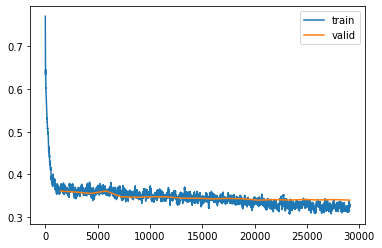

In [27]:
tab_learn.recorder.plot_loss()

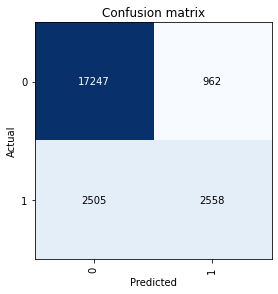

In [28]:
interpret = ClassificationInterpretation.from_learner(tab_learn)
interpret.plot_confusion_matrix()

SuggestedLRs(valley=0.0012022644514217973)

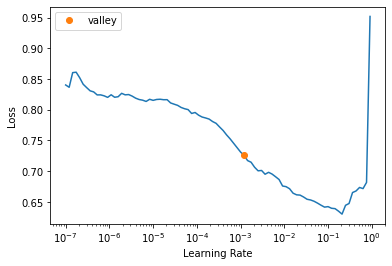

In [29]:
tab_learn_ru.lr_find()

In [30]:
tab_learn_ru.fit_one_cycle(20, lr_max=0.005)

epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,f1_score,precision_score,time
0,0.475205,0.458941,0.781891,0.218109,0.795517,0.786093,0.776889,00:05
1,0.473558,0.469961,0.775017,0.224983,0.751462,0.770923,0.791419,00:05
2,0.474184,0.456795,0.785427,0.214573,0.775828,0.784623,0.793619,00:05
3,0.469209,0.474802,0.777570,0.222430,0.833333,0.790569,0.751979,00:05
4,0.466961,0.457518,0.782972,0.217028,0.780702,0.783757,0.786837,00:05
5,0.457775,0.450175,0.787096,0.212904,0.830214,0.797118,0.766559,00:05
6,0.452323,0.448598,0.787194,0.212806,0.780702,0.787069,0.793541,00:05
7,0.455289,0.449685,0.791417,0.208583,0.802924,0.795020,0.787271,00:05
8,0.448695,0.444297,0.787489,0.212511,0.809162,0.793235,0.777924,00:05
9,0.436137,0.447059,0.786114,0.213886,0.783821,0.786888,0.789980,00:05


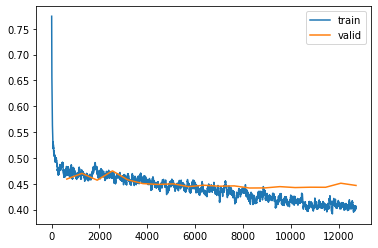

In [31]:
tab_learn_ru.recorder.plot_loss()

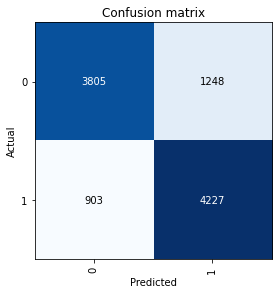

In [32]:
interpret_ru = ClassificationInterpretation.from_learner(tab_learn_ru)
interpret_ru.plot_confusion_matrix()

SuggestedLRs(valley=0.0008317637839354575)

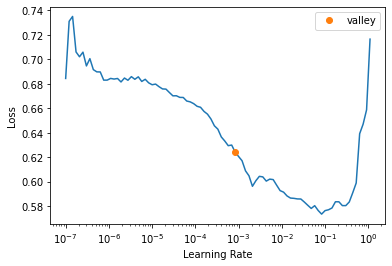

In [33]:
tab_learn_ro.lr_find()

In [34]:
tab_learn_ro.fit_one_cycle(20, lr_max=0.001)

epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,f1_score,precision_score,time
0,0.463979,0.454782,0.783345,0.216655,0.774749,0.780911,0.787172,00:19
1,0.454685,0.445286,0.791623,0.208377,0.818949,0.796640,0.775513,00:19
2,0.449668,0.441474,0.793548,0.206452,0.813707,0.797103,0.781162,00:19
3,0.447246,0.433699,0.795748,0.204252,0.812548,0.798601,0.785124,00:19
4,0.435393,0.436357,0.795143,0.204857,0.789703,0.793491,0.797315,00:19
5,0.451119,0.428039,0.801221,0.198779,0.833021,0.806841,0.782257,00:19
6,0.422383,0.431200,0.798223,0.201777,0.814756,0.800987,0.787677,00:19
7,0.430305,0.417688,0.805951,0.194049,0.807527,0.805748,0.803978,00:19
8,0.410397,0.420418,0.806529,0.193471,0.849630,0.814032,0.781296,00:19
9,0.417862,0.414030,0.808069,0.191931,0.844278,0.814285,0.786349,00:19


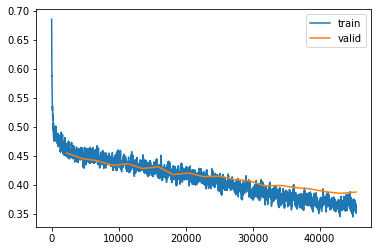

In [35]:
tab_learn_ro.recorder.plot_loss()

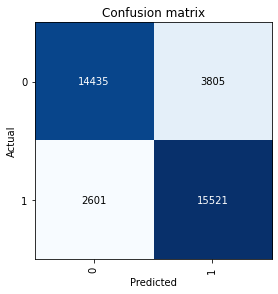

In [36]:
interpret_ro = ClassificationInterpretation.from_learner(tab_learn_ro)
interpret_ro.plot_confusion_matrix()

## Performance sur Train

In [37]:
interpret.print_classification_report()

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     18209
           1       0.73      0.51      0.60      5063

    accuracy                           0.85     23272
   macro avg       0.80      0.73      0.75     23272
weighted avg       0.84      0.85      0.84     23272



In [38]:
interpret_ru.print_classification_report()

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      5053
           1       0.77      0.82      0.80      5130

    accuracy                           0.79     10183
   macro avg       0.79      0.79      0.79     10183
weighted avg       0.79      0.79      0.79     10183



In [39]:
interpret_ro.print_classification_report()

              precision    recall  f1-score   support

           0       0.85      0.79      0.82     18240
           1       0.80      0.86      0.83     18122

    accuracy                           0.82     36362
   macro avg       0.83      0.82      0.82     36362
weighted avg       0.83      0.82      0.82     36362



## Test du modèle sur les données de test

In [40]:
test = tab_learn.dls.test_dl(X_te)
test.show_batch()

,Rainfall,Rain_J-1,Rain_J-2,MinTemp,MaxTemp,Sunshine,Evaporation,Humidity3pm,Humidity9am,Pressure9am,Pressure3pm,Wind9am_cos,Wind3pm_cos,WindGust_cos,Wind9am_sin,Wind3pm_sin,WindGust_sin,Mois_sin,Mois_cos,RainToday_Num,Cloud3pm,Cloud9am,RainTomorrow_Num
0,0.0,0.0,0.0,2.0,18.000000,6.80,4.20,33.0,62.0,1022.099976,1018.299988,1.000000e+00,9.238795e-01,9.238795e-01,0.000000,-0.382683,-3.826834e-01,5.000000e-01,-8.660254e-01,0.0,6.0,2.0,0
1,1.2,0.0,0.0,6.2,14.000000,5.50,2.00,62.0,56.0,1015.599976,1014.200012,-7.071068e-01,-7.071068e-01,-9.238795e-01,-0.707107,-0.707107,-3.826834e-01,-8.660254e-01,-5.000000e-01,1.0,6.0,6.0,0
2,0.0,0.0,0.0,15.2,25.700001,11.50,13.40,30.0,56.0,1017.200012,1015.099976,-1.836970e-16,-3.826834e-01,-3.826834e-01,-1.000000,-0.923880,-9.238795e-01,5.000000e-01,8.660254e-01,0.0,1.0,0.0,0
3,0.0,0.0,0.0,21.0,26.600000,2.56,5.64,76.0,86.0,1007.500000,1006.900024,1.913417e-01,-1.836970e-16,-1.836970e-16,0.961940,-1.000000,-1.000000e+00,-8.660254e-01,5.000000e-01,0.0,6.0,6.0,0
4,0.0,0.0,0.0,15.0,29.700001,0.40,10.60,39.0,26.0,1004.900024,1006.099976,6.123234e-17,7.071068e-01,-1.000000e+00,1.000000,0.707107,1.224647e-16,0.000000e+00,1.000000e+00,0.0,7.0,7.0,1
5,0.0,0.0,1.0,9.4,18.900000,5.30,3.00,53.0,60.0,1021.200012,1019.500000,-7.071068e-01,-3.826834e-01,-9.238795e-01,0.707107,0.923880,3.826834e-01,1.224647e-16,-1.000000e+00,0.0,3.0,5.0,0
6,0.0,0.0,0.0,11.9,33.200001,9.94,6.84,32.0,69.0,1020.000000,1015.299988,-9.238795e-01,7.071068e-01,1.000000e+00,0.382683,0.707107,0.000000e+00,5.000000e-01,8.660254e-01,0.0,3.0,2.0,0
7,0.0,0.0,0.0,22.4,30.799999,7.90,9.00,56.0,63.0,1017.000000,1014.500000,9.238795e-01,1.000000e+00,1.000000e+00,-0.382683,0.000000,0.000000e+00,-1.000000e+00,-1.836970e-16,0.0,7.0,7.0,0
8,0.0,1.0,1.0,23.9,34.599998,6.54,4.80,61.0,70.0,1009.000000,1005.400024,-7.071068e-01,7.071068e-01,-1.836970e-16,0.707107,0.707107,-1.000000e+00,-8.660254e-01,5.000000e-01,0.0,5.0,5.0,0
9,0.0,0.0,0.0,3.3,12.200000,6.20,1.20,66.0,92.0,1026.000000,1022.799988,-3.826834e-01,-3.826834e-01,-3.826834e-01,0.923880,0.923880,9.238795e-01,1.224647e-16,-1.000000e+00,0.0,4.0,5.0,0


In [41]:
preds, test_labels = tab_learn.get_preds(dl=test)

In [42]:
preds

tensor([[0.9336, 0.0664],
        [0.7322, 0.2678],
        [0.9980, 0.0020],
        ...,
        [0.8934, 0.1066],
        [0.9578, 0.0422],
        [0.5486, 0.4514]])

In [43]:
final_preds = preds.numpy()
final_preds = np.argmax(final_preds, axis=1)

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
print("performances sur test :\n", classification_report(X_te.RainTomorrow_Num, final_preds))

performances sur test :
               precision    recall  f1-score   support

           0       0.87      0.94      0.91     22673
           1       0.72      0.51      0.59      6418

    accuracy                           0.85     29091
   macro avg       0.79      0.72      0.75     29091
weighted avg       0.84      0.85      0.84     29091



In [47]:
preds, test_labels = tab_learn_ro.get_preds(dl=test)
final_preds = preds.numpy()
final_preds = np.argmax(final_preds, axis=1)
from sklearn.metrics import classification_report, confusion_matrix
print("performances sur test - oversampling :\n", classification_report(X_te.RainTomorrow_Num, final_preds))

performances sur test - oversampling :
               precision    recall  f1-score   support

           0       0.93      0.79      0.85     22673
           1       0.51      0.79      0.62      6418

    accuracy                           0.79     29091
   macro avg       0.72      0.79      0.73     29091
weighted avg       0.84      0.79      0.80     29091



In [48]:
preds, test_labels = tab_learn_ru.get_preds(dl=test)
final_preds = preds.numpy()
final_preds = np.argmax(final_preds, axis=1)
from sklearn.metrics import classification_report, confusion_matrix
print("performances sur test - undersampling :\n", classification_report(X_te.RainTomorrow_Num, final_preds))

performances sur test - undersampling :
               precision    recall  f1-score   support

           0       0.94      0.75      0.84     22673
           1       0.49      0.83      0.61      6418

    accuracy                           0.77     29091
   macro avg       0.71      0.79      0.72     29091
weighted avg       0.84      0.77      0.79     29091



## Conclusion FastAI

Les performances obtenues avec sur ou sous-échantillonnage conduisent aux mêmes conclusions que pour les réseaux de neurones denses classiques.

<hr>
<h1> Conclusion générale sur les modèles de Deep Learning</h1>
<hr>

- Les modèles de Deep Learning développés n’ont pas démontré de meilleurs résultats que les modèles de machine learning étudiés en début de projet.
- Par ailleurs, au-delà des performances peu convaincantes sur notre jeu de données, le manque d’interprétabilité des modèles de Deep Learning par rapport au machine learning ne pousse pas à les développer davantage lors de ce projet.